In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_1444527/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-07-03"
ORG_NAME = "DAOSquare Grants"
SPLITS_FREQ = "W-FRI"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2021-07-02"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 880 non-null    object        
 1   author             880 non-null    object        
 2   date               880 non-null    datetime64[us]
 3   start              880 non-null    datetime64[us]
 4   end                739 non-null    datetime64[us]
 5   platform_proposal  880 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 41.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        702 non-null    object        
 1   proposal  702 non-null    object        
 2   voter     702 non-null    object        
 3   date      702 non-null    datetime64[us]
dtypes: dat

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['t'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('t')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

t
2022-02-25    701
2022-03-04    701
2022-03-11    701
2022-03-18    701
2022-03-25    701
2022-04-01    701
2022-04-08    701
2022-04-15    701
2022-04-22    701
2022-04-29    701
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
t,,,,,,,,,
2022-W08,0,0,0,nan,nan,0,0,nan,nan
2022-W09,0,0,0,nan,nan,0,0,nan,nan
2022-W10,0,0,0,nan,nan,0,0,nan,nan
2022-W11,0,0,0,nan,nan,0,0,nan,nan
2022-W12,0,0,0,nan,nan,0,0,nan,nan
2022-W13,0,0,0,nan,nan,0,0,nan,nan
2022-W14,0,0,0,nan,nan,0,0,nan,nan
2022-W15,0,0,0,nan,nan,0,0,nan,nan
2022-W16,0,0,0,nan,nan,0,0,nan,nan


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
t &  &  &  &  &  &  &  &  &  \\
2022-W08 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2022-W09 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2022-W10 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2022-W11 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2022-W12 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2022-W13 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2022-W14 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2022-W15 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2022-W16 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
2022-W17 & 0 & 0 & 0 & nan & nan & 0 & 0 & nan & nan \\
\end{tabular}



## Running openpop baseline

In [9]:
folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i}", file=sys.stderr)

    mdict = {'t': t}
    pdict = {'t': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)

  0%|          | 0/48 [00:00<?, ?it/s]

Warning, empty test fold 2
Warning, empty test fold 3


Warning, empty test fold 4
Warning, empty test fold 5


Warning, empty test fold 6
Warning, empty test fold 7


Warning, empty test fold 8
Warning, empty test fold 9


Warning, empty test fold 10
Warning, empty test fold 11


Warning, empty test fold 12
Warning, empty test fold 13


Warning, empty test fold 14
Warning, empty test fold 15


Warning, empty test fold 16
Warning, empty test fold 17


Warning, empty test fold 18
Warning, empty test fold 19


Warning, empty test fold 20
Warning, empty test fold 21


Warning, empty test fold 22
Warning, empty test fold 23


Warning, empty test fold 24
Warning, empty test fold 25


Warning, empty test fold 26
Warning, empty test fold 27


Warning, empty test fold 28
Warning, empty test fold 29


Warning, empty test fold 30
Warning, empty test fold 31


Warning, empty test fold 32
Warning, empty test fold 33


Warning, empty test fold 34
Warning, empty test fold 35


Warning, empty test fold 36
Warning, empty test fold 37


Warning, empty test fold 38
Warning, empty test fold 39


Warning, empty test fold 40
Warning, empty test fold 41


Warning, empty test fold 42
Warning, empty test fold 43


Warning, empty test fold 44
Warning, empty test fold 45


Warning, empty test fold 46
Warning, empty test fold 47


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("t")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/DAOSquare Grants/baseline/openpop_W-FRI_normalize.pq


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,...,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069383
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002414
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067956
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068576
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068957
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069312
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083391


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("t")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/DAOSquare Grants/baseline/perfect_W-FRI_normalize.pq


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,...,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,0.041667,0.034722,0.033333,0.032292,0.031944,0.022500,0.041667,0.041667,0.041667,0.041667,...,0.018031,0.021838,0.027532,0.011178,0.012701,0.014224,0.018031,0.021838,0.027532,0.075210
std,0.201941,0.171760,0.166738,0.163242,0.162131,0.144554,0.201941,0.201941,0.201941,0.201941,...,0.120272,0.144357,0.150673,0.076972,0.086584,0.096204,0.120272,0.144357,0.150673,0.012878
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071843
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072281
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072422
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072709
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.833333,1.000000,1.000000,0.533333,0.600000,0.666667,0.833333,1.000000,1.000000,0.144401


## Plotting some graphs

,t,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,48,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.0,...,48.0,48.0,48.0,48.0,48.0,48.0,48.0,48.000000,0.0,0.0
mean,2021-11-15 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069383,NaN,NaN
min,2021-06-04 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067956,NaN,NaN
25%,2021-08-25 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068576,NaN,NaN
50%,2021-11-15 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068957,NaN,NaN
75%,2022-02-05 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069312,NaN,NaN
max,2022-04-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083391,NaN,NaN
std,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002414,NaN,NaN


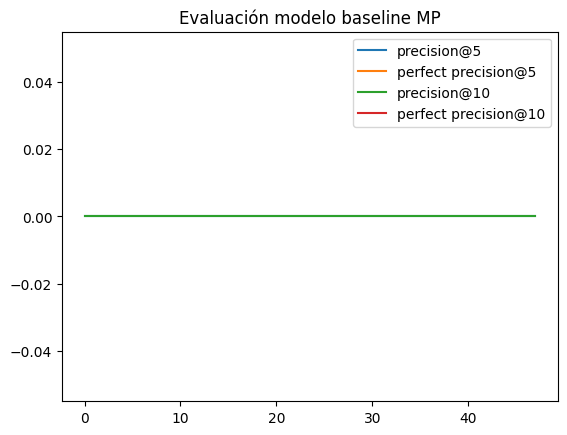

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,t,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.000000,0.0,0.0
mean,2022-03-28 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068856,NaN,NaN
min,2022-02-25 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067956,NaN,NaN
25%,2022-03-12 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068372,NaN,NaN
50%,2022-03-28 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068772,NaN,NaN
75%,2022-04-13 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069328,NaN,NaN
max,2022-04-29 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.069767,NaN,NaN
std,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000653,NaN,NaN
